# Covid-19 em 2021, Brasil-ES

No último notebook (de limpeza de dados) ajustei a base de dados para iniciar o trabalho de entender a Covid-19 no Espírito Santo. Neste notebook vou analizar que características de grupo levam a uma maior taxa de mortalidade.

## Sumário

1. Limpeza
2. Análise uni-variável
3. Análise bi-variável
4. Análise multi-variável

## Limpeza

Fizemos a maior parte da limpeza no notebook anterior, mas ainda precisamos importar as bibliotecas e base, confirmar que todas as colunas foram importadas com o datatype correto, criar novas features que serão necessárias e possivelmente remover colunas que tem pouco ou nenhum impacto na análise desejada.

Inicialmente vou importar as bibliotecas necessárias, a base e conferir o tipo de dado.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
df=pd.read_csv("covid19ES.csv", sep=";")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596156 entries, 0 to 1596155
Data columns (total 45 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   DataNotificacao          1596156 non-null  object
 1   DataCadastro             1596156 non-null  object
 2   DataDiagnostico          1596156 non-null  object
 3   DataColeta_RT_PCR        788792 non-null   object
 4   DataColetaTesteRapido    565823 non-null   object
 5   DataColetaSorologia      86868 non-null    object
 6   DataColetaSorologiaIGG   133718 non-null   object
 7   DataEncerramento         1368896 non-null  object
 8   DataObito                14534 non-null    object
 9   Classificacao            1596156 non-null  object
 10  Evolucao                 1596156 non-null  object
 11  CriterioConfirmacao      1596156 non-null  object
 12  StatusNotificacao        1596156 non-null  object
 13  Municipio                1596156 non-null  object
 14  Ba

Primeiro vou remover algumas colunas que não serão utilizadas na análise:

In [4]:
df.drop(columns=['DataNotificacao','DataEncerramento','DataCadastro','DataColeta_RT_PCR','DataColetaTesteRapido','DataColetaSorologia','DataColetaSorologiaIGG','Municipio','Bairro','ResultadoRT_PCR','ResultadoTesteRapido','ResultadoSorologia','ResultadoSorologia_IGG','TipoTesteRapido'], inplace=True)

Vou transfomar as colunas de data em formato `datetime`.

In [5]:
df.DataDiagnostico=pd.to_datetime(df.DataDiagnostico,format='%Y-%m-%d')
df.DataObito=pd.to_datetime(df.DataObito,format='%Y-%m-%d')

Vou criar a coluna `Obito` com 0 se ele não faleceu por Covid e 1 se faleceu

In [6]:
df['Obito']=df.Evolucao.apply(lambda x: 1 if x=="Óbito pelo COVID-19" else 0)

Vou agrupar os dados de `Escolaridade` e reduzir os textos para ficar mais legível a análise posterior

In [7]:
df.Escolaridade=df.Escolaridade.replace('Ensino médio completo (antigo colegial ou 2º grau ) ','EM completo')
df.Escolaridade=df.Escolaridade.replace('5ª à 8ª série incompleta do EF (antigo ginásio ou 1º grau)','EF incompleto')
df.Escolaridade=df.Escolaridade.replace('Ensino fundamental completo (antigo ginásio ou 1º grau) ','EF completo')
df.Escolaridade=df.Escolaridade.replace('Ensino médio incompleto (antigo colegial ou 2º grau )','EF completo')
df.Escolaridade=df.Escolaridade.replace('4ª série completa do EF (antigo primário ou 1º grau)','EF completo')
df.Escolaridade=df.Escolaridade.replace('1ª a 4ª série incompleta do EF (antigo primário ou 1º grau)','EF incompleto')

Vou criar duas colunas novas com o ano-semana do óbito e do diagnostico

In [8]:
df['SemanaDiagnostico']=df.DataDiagnostico.dt.year*100+df.DataDiagnostico.dt.weekofyear
df['SemanaObito']=df.DataObito.dt.year*100+df.DataObito.dt.weekofyear
df['SemanaObito']=df['SemanaObito'].fillna(0).astype(int)

Vou remover todos os dados depois da 24ª semana de 2021 para excluir a demora de notificação

In [9]:
df.drop(df[(df['DataDiagnostico'].dt.weekofyear>24) & (pd.DatetimeIndex(df['DataDiagnostico']).year==2021)].index,inplace=True)
df.drop(df[(df['DataObito'].dt.weekofyear>24) & (pd.DatetimeIndex(df['DataObito']).year==2021)].index,inplace=True)

Vou criar mais duas colunas contendo o número de comorbidades e se o paciente tem alguma comorbidade de qualquer tipo.

In [10]:
df["NumeroComorbidade"]=df['ComorbidadePulmao'].astype(int)+df['ComorbidadeCardio'].astype(int)+df['ComorbidadeRenal'].astype(int)+ df['ComorbidadeDiabetes'].astype(int)+df['ComorbidadeTabagismo'].astype(int)+df['ComorbidadeObesidade'].astype(int)
df["Comorbidade"]=df.NumeroComorbidade.apply(lambda x: True if x>0 else False)

Queremos apenas estudar óbitos por Covid-19, então vou remover casos que o paciente na verdade era apenas suspeito, mas não se confirmou, ou se confirmou que não era Covid, ou se ele faleceu por outras causas

In [11]:
df.drop(index=df[df.Evolucao.str.contains('Óbito por outras causas')==True].index,inplace=True)

In [12]:
df.drop(index=df[df.Classificacao.str.contains('Descartados')==True].index,inplace=True)
df.drop(index=df[df.Classificacao.str.contains('Suspeito')==True].index,inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506402 entries, 0 to 1596146
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DataDiagnostico          506402 non-null  datetime64[ns]
 1   DataObito                11157 non-null   datetime64[ns]
 2   Classificacao            506402 non-null  object        
 3   Evolucao                 506402 non-null  object        
 4   CriterioConfirmacao      506402 non-null  object        
 5   StatusNotificacao        506402 non-null  object        
 6   FaixaEtaria              506402 non-null  object        
 7   IdadeNaDataNotificacao   506402 non-null  int64         
 8   Sexo                     506402 non-null  object        
 9   RacaCor                  506402 non-null  object        
 10  Escolaridade             506402 non-null  object        
 11  Gestante                 506402 non-null  object        
 12  Febre          

Agora os dados estão limpos para iniciar a análise. Primeiro vou fazer uma análise de uni-variável para entender como cada uma delas se comporta.

## Univariate Exploration

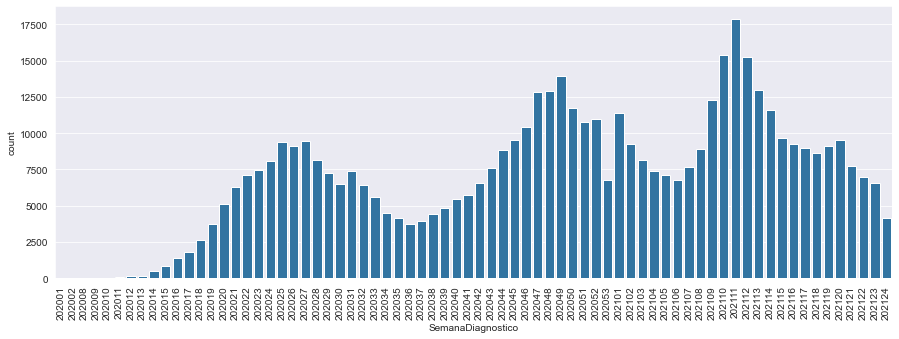

In [14]:
base_color = sns.color_palette()[0]
plt.figure(figsize=[15,5])
sns.countplot(data=df, x='SemanaDiagnostico', color=base_color);
plt.xticks(rotation=90);

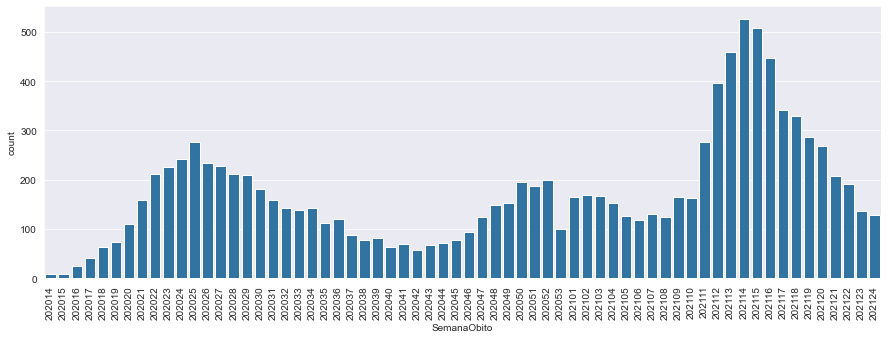

In [15]:
plt.figure(figsize=[15,5])
sns.countplot(data=df[df['SemanaObito']>0], x='SemanaObito', color=base_color);
plt.xticks(rotation=90);

A distribuição de Diagnósticos e óbitos são mto parecidas, no geral com duas semanas de distancia entre os diagnósticos e os óbitos. Os picos foram respectivamente na 11ª e 14ª semana de 2021

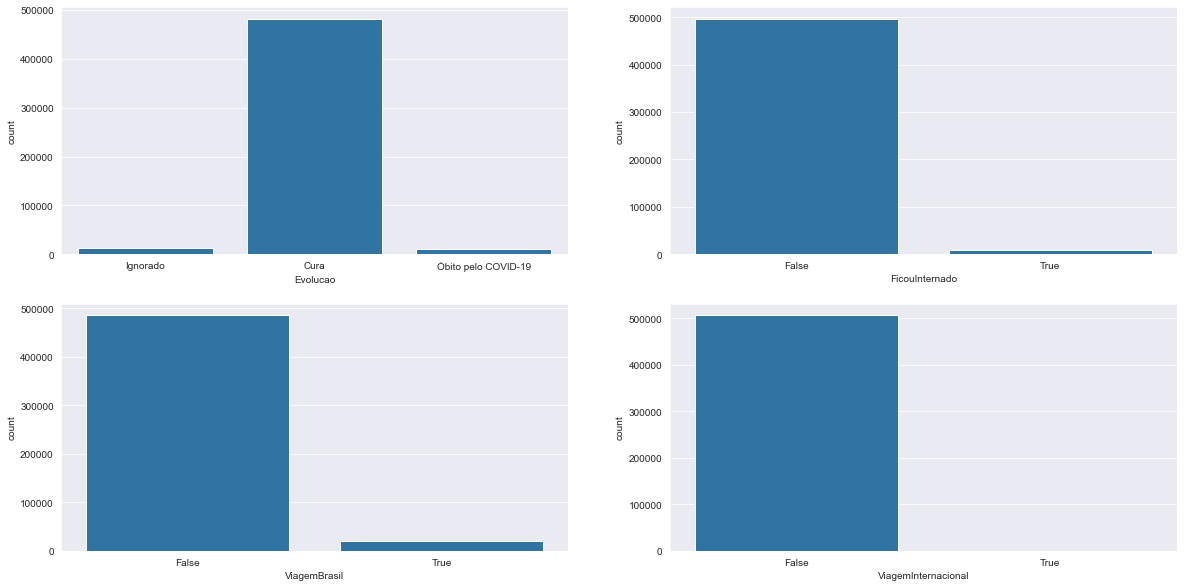

In [16]:
columns=['Evolucao', 'FicouInternado', 'ViagemBrasil', 'ViagemInternacional']

plt.figure(figsize = [20, 10]) 
i=0
while i <len(columns):
    plt.subplot(2, 2, (i+1)) 
    sns.countplot(data=df, x=columns[i], color=base_color);
    i=i+1

A maioria dos pacientes se curaram, não foram internados, não viajaram nem pelo Brasil nem intrenacionalmente.

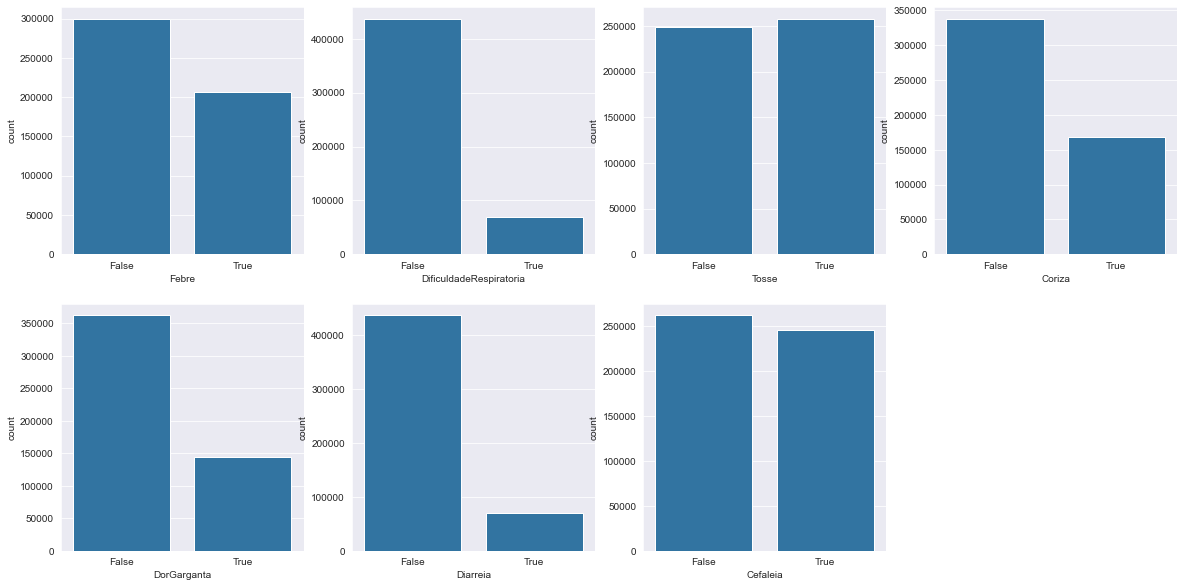

In [17]:
columns=['Febre', 'DificuldadeRespiratoria', 'Tosse', 'Coriza', 'DorGarganta',
       'Diarreia', 'Cefaleia']

plt.figure(figsize = [20, 10]) 
i=0
while i <len(columns):
    plt.subplot(2, 4, (i+1)) 
    sns.countplot(data=df, x=columns[i], color=base_color);
    i=i+1

Os sintomas mais comuns foram tosse e cefaleia e os menos comuns foram diarreia e dificuldade respiratória

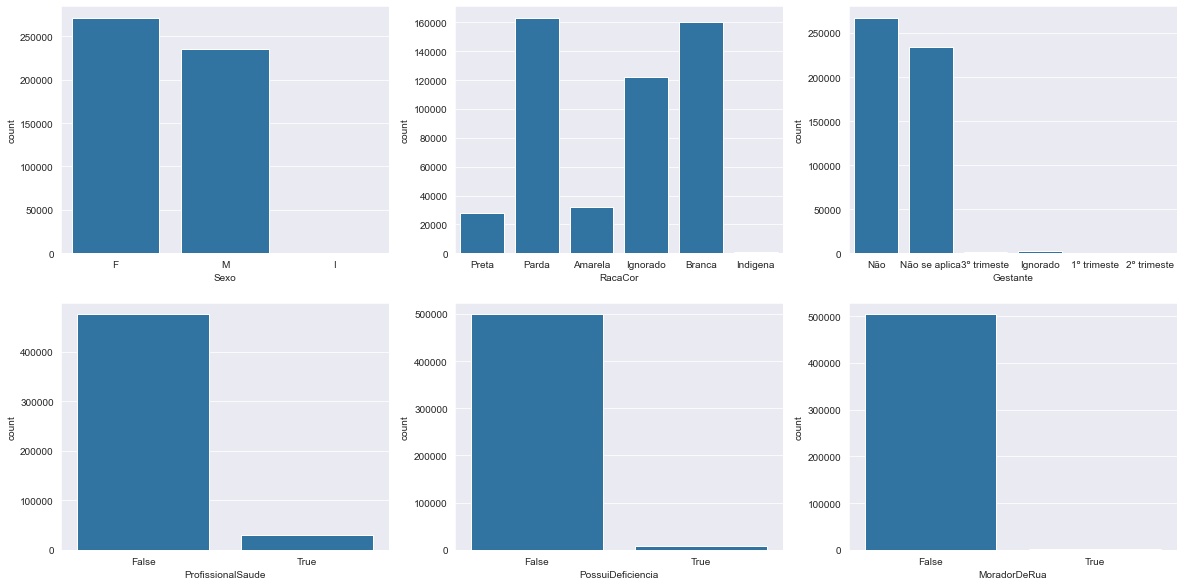

In [18]:
columns=['Sexo', 'RacaCor', 'Gestante', 'ProfissionalSaude', 'PossuiDeficiencia','MoradorDeRua']

#Plot for the social features
plt.figure(figsize = [20, 10]) 
i=0
while i <len(columns):
    plt.subplot(2, 3, (i+1)) 
    sns.countplot(data=df, x=columns[i],color=base_color);
    i=i+1

Temos um pouco mais mulheres que homens, a maioria das pessoas são pardas, brancas, ou tiveram a cor ignorada. Temos poucas gestantes, poucos profissionais de saúde, pessoas com deficiência ou morador de rua.

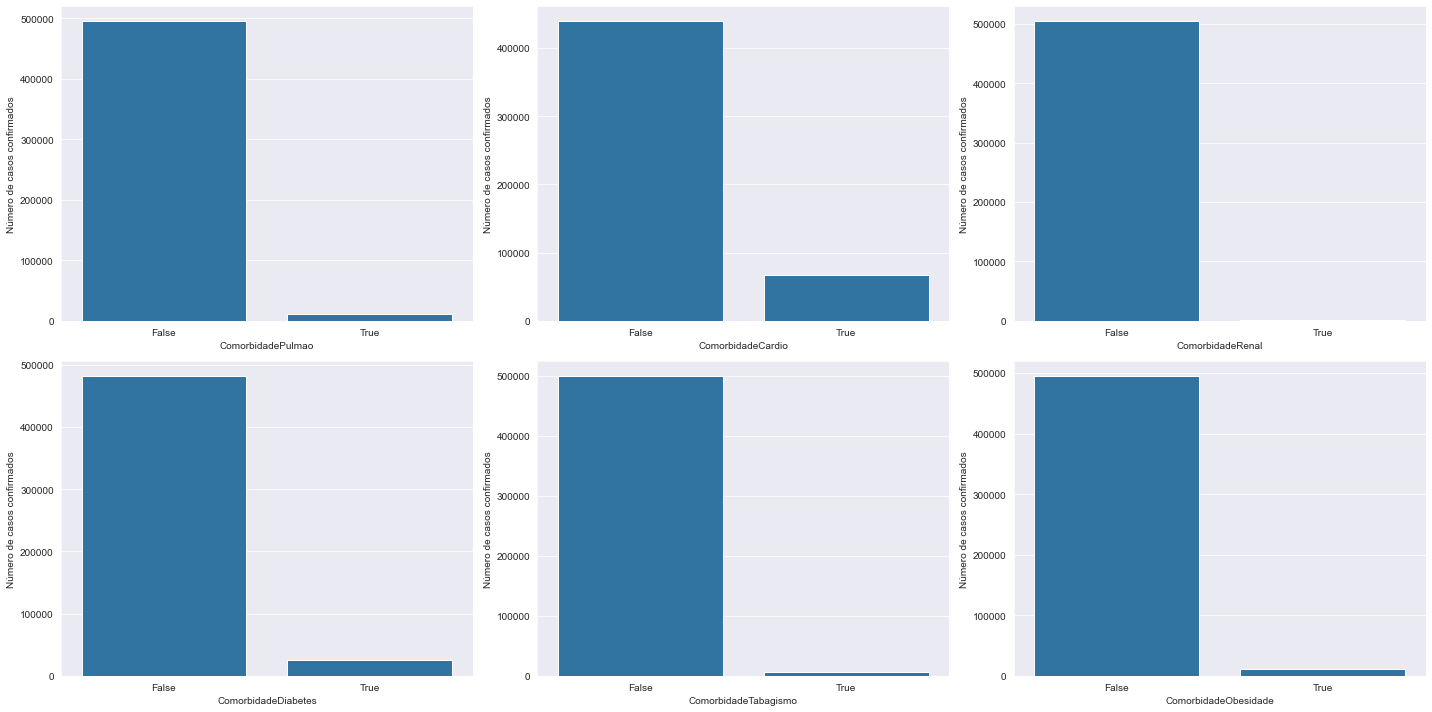

In [19]:
columns=['ComorbidadePulmao', 'ComorbidadeCardio', 'ComorbidadeRenal', 'ComorbidadeDiabetes', 'ComorbidadeTabagismo','ComorbidadeObesidade']

plt.figure(figsize = [20, 10]) 
i=0
while i <len(columns):
    plt.subplot(2, 3, (i+1)) 
    sns.countplot(data=df, x=columns[i],color=base_color);
    plt.ylabel('Número de casos confirmados')
    i=i+1
plt.tight_layout()
plt.savefig('DistComorb')

Poucos pacientes tem comorbidades, mas as mais comuns são cardíacas e diabetes.

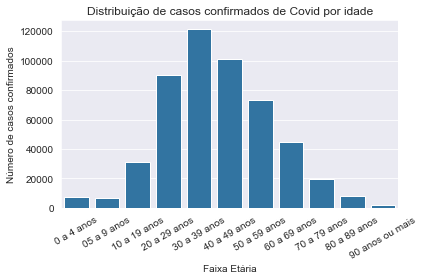

In [20]:
#Reorder the age feature to be ascending
agescl = ['0 a 4 anos', '05 a 9 anos', '10 a 19 anos', '20 a 29 anos', '30 a 39 anos', '40 a 49 anos', '50 a 59 anos', '60 a 69 anos', '70 a 79 anos', '80 a 89 anos', '90 anos ou mais']
agesclasses = pd.api.types.CategoricalDtype(ordered=True, categories=agescl)
df['FaixaEtaria'] = df['FaixaEtaria'].astype(agesclasses);

#Plot age data
sns.countplot(data=df, x='FaixaEtaria', color=base_color);
plt.title('Distribuição de casos confirmados de Covid por idade')
plt.xlabel("Faixa Etária")
plt.ylabel("Número de casos confirmados")
plt.xticks(rotation=30);
plt.tight_layout()
plt.savefig('DistIdade')

A maior parte dos pacientes tiveram idade entre 10 e 49 anos.

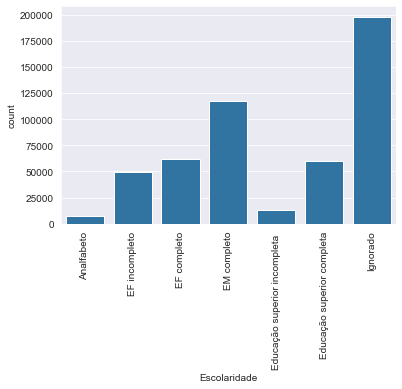

In [21]:
schcl = ['Analfabeto', 'EF incompleto', 'EF completo', 
         'EM completo', 'Educação superior incompleta ', 'Educação superior completa', 'Ignorado']
schclasses = pd.api.types.CategoricalDtype(ordered=True, categories=schcl)
df['Escolaridade'] = df['Escolaridade'].astype(schclasses);
sns.countplot(data=df, x='Escolaridade', color=base_color);
plt.xticks(rotation=90);

Muitos pacientes tiveram seu grau de escolaridade ignorado, por outro lado a maior parte dos pacientes teve ensino médio completo.

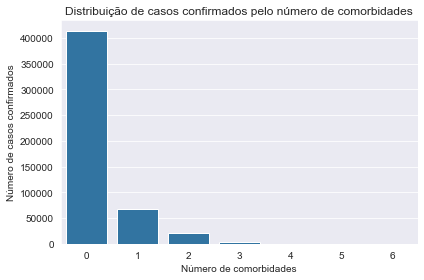

In [22]:
sns.countplot(data=df, x='NumeroComorbidade', color=base_color);
plt.tight_layout()
plt.xlabel('Número de comorbidades');
plt.ylabel('Número de casos confirmados')
plt.title('Distribuição de casos confirmados pelo número de comorbidades')
plt.tight_layout()
plt.savefig('DistNumComorb')

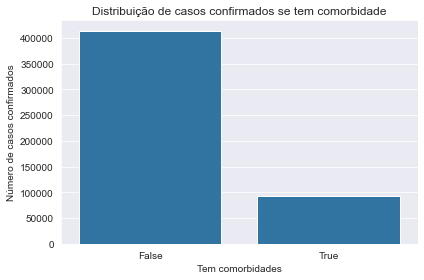

In [23]:
sns.countplot(data=df, x='Comorbidade', color=base_color);
plt.xlabel('Tem comorbidades');
plt.ylabel('Número de casos confirmados')
plt.title('Distribuição de casos confirmados se tem comorbidade')
plt.tight_layout()
plt.savefig('DistComorb1')

Poucos pacientes tem comorbidades, e os que tem dificilmente tem mais que duas.

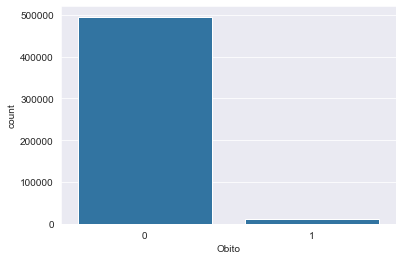

In [24]:
sns.countplot(data=df, x='Obito', color=base_color);

Muito mais pacientes se curaram do que faleceram.

A partir de agora vou buscar entender quais características tem maior taxa de mortalidade. Vou explorar 3 possibilidades:

- Fatores da doença: Por exemplo, qual sintoma é mais grave? Se o paciente foi internado quanto mais risco ele tem? Que épocas do ano a doença foi mais letal (possivelmente por conta de variantes)?
- Fatores biológicos: Levando em consideração idade, gravidez, comorbidades, etc.
- Fatores sociais: Levando em consideração escolaridade, se viajou, cor, etc.

## Exploração bi-variável

### Fatores da doença

### Qual a taxa de mortalidade pelo tempo?

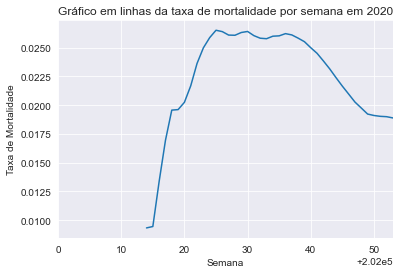

In [25]:
df=df.sort_values(by=['SemanaDiagnostico'])
#Count the number of diagnostics and deaths every week
x=df.groupby(by=['SemanaDiagnostico']).count()['DataDiagnostico']
y=df[df['Obito']==1].groupby(by=['Evolucao', 'SemanaObito']).count()['DataObito'].loc['Óbito pelo COVID-19']
#Calculate the cummulative sum and divide them
s=y.cumsum()/x.cumsum()
plt.title('Gráfico em linhas da taxa de mortalidade por semana em 2020')
plt.ylabel('Taxa de Mortalidade')
plt.xlabel('Semana')
plt.plot(s);
plt.xlim(202000,202053);

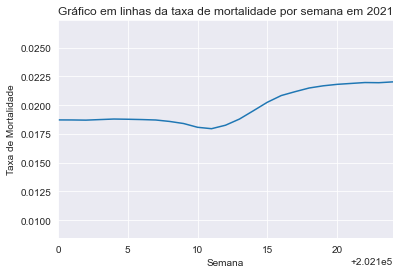

In [26]:
plt.plot(s);
plt.title('Gráfico em linhas da taxa de mortalidade por semana em 2021')
plt.ylabel('Taxa de Mortalidade')
plt.xlabel('Semana')
plt.xlim(202100,202124);

A mortalidade subiu rapidamente até o meio do ano passado alcançando mais de 2.5%, depois reduziu e se estabilizou em 2% até subir novamente a partir da 14ª semana se estabilizando em cerca de 2.3%

### Quais sintomas tem  maior gravidade e mortalidade?

In [27]:
lista=[]
symptoms=['Febre', 'DificuldadeRespiratoria', 'Tosse', 'Coriza', 'DorGarganta',
       'Diarreia', 'Cefaleia']
#Get the mortality rate for every symptom
for i in symptoms:
    x=[i, len(df[(df[i]==True) & (df['Obito']==1)])/len(df[(df[i]==True)])]
    lista.append(x)

#Transform the list to a dataframe
symptom=pd.DataFrame(lista, columns=['Sintoma', 'Mortalidade'])

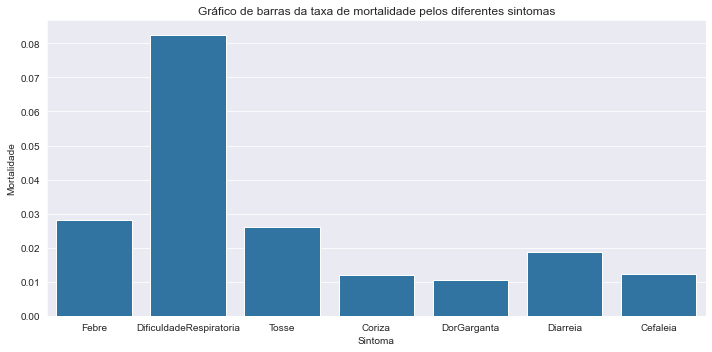

In [28]:
base_color = sns.color_palette()[0]
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="Sintoma", y="Mortalidade", data=symptom, color=base_color)
plt.title('Gráfico de barras da taxa de mortalidade pelos diferentes sintomas')
plt.tight_layout()

Dificuldade de respirar, como esperado é o sintoma mais grave, com uma mortalidade de 8%, enquanto dor de garganta é o menos, com cerca de 1.2%

### Qual o impacto da internação na taxa de mortalidade?

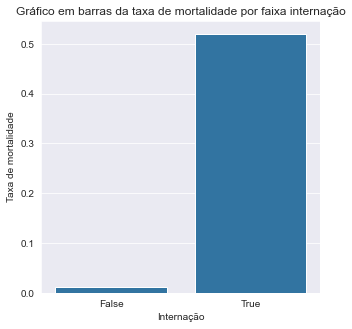

In [29]:
plt.figure(figsize = [5, 5]) 
ax = sns.barplot(x="FicouInternado", y="Obito", data=df, ci=0, color=base_color)
#Polish plot
plt.title('Gráfico em barras da taxa de mortalidade por faixa internação');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Internação');

Como esperado, internações são muito preocupantes, com uma taxa de mortalidade acima de 50%, enquanto quem não foi internado tem uma taxa de mortalidade abaixo de 2%

### Qual impacto de comorbidades na taxa de mortalidade?

In [30]:
lista=[]
comorbidities=['ComorbidadePulmao', 'ComorbidadeCardio', 'ComorbidadeRenal', 'ComorbidadeDiabetes', 'ComorbidadeTabagismo','ComorbidadeObesidade']

#Get the mortality rate for every comorbidity
for i in comorbidities:
    x=[i, len(df[(df[i]==True) & (df['Obito']==1)])/len(df[(df[i]==True)])]
    lista.append(x)

#Transform the list to a dataframe
comorbidity=pd.DataFrame(lista, columns=['Comorbidade', 'Taxa de mortalidade'])

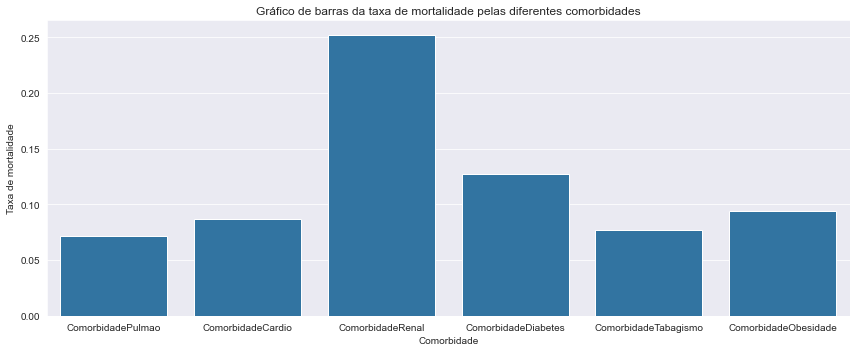

In [31]:
plt.figure(figsize = [12, 5]) 
ax = sns.barplot(x="Comorbidade", y="Taxa de mortalidade", data=comorbidity, color=base_color)
plt.title('Gráfico de barras da taxa de mortalidade pelas diferentes comorbidades')
plt.tight_layout()
plt.savefig('MortComorbs')

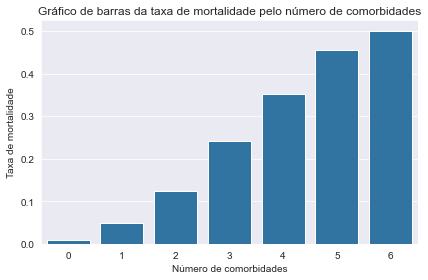

In [32]:
plt.figure(figsize = [6, 4])
ax = sns.barplot(x="NumeroComorbidade", y="Obito", data=df, ci=0, color=base_color)
#Polish plot
plt.title('Gráfico de barras da taxa de mortalidade pelo número de comorbidades')
plt.tight_layout()
plt.xlabel('Número de comorbidades')
plt.ylabel('Taxa de mortalidade')
plt.savefig('MortNumComorb')

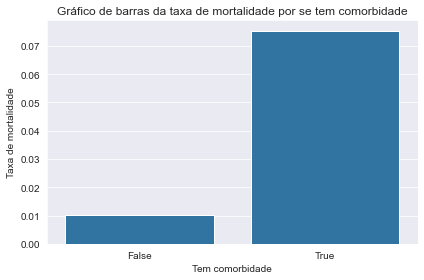

In [33]:
plt.figure(figsize = [6, 4]) 
ax = sns.barplot(x="Comorbidade", y="Obito", data=df, ci=0, color=base_color)
#Polish plot
plt.title('Gráfico de barras da taxa de mortalidade por se tem comorbidade')
plt.tight_layout()
plt.xlabel('Tem comorbidade')
plt.ylabel('Taxa de mortalidade')
plt.savefig('MortComorb')

Como esperado pessoas com comorbidade tem maior taxa de mortalidade (cerca 7.5% contra 1% de quem não tem). A taxa de mortalidade aumenta com o número de comorbidades, chegando a 50% para pessoas com 6 comorbidades. Dentro as diferentes comorbidades, a Renal não é comum, mas tem a maior taxa de mortalidade, cerca de 25%.

### Qual impacto da idade na taxa de mortalidade?

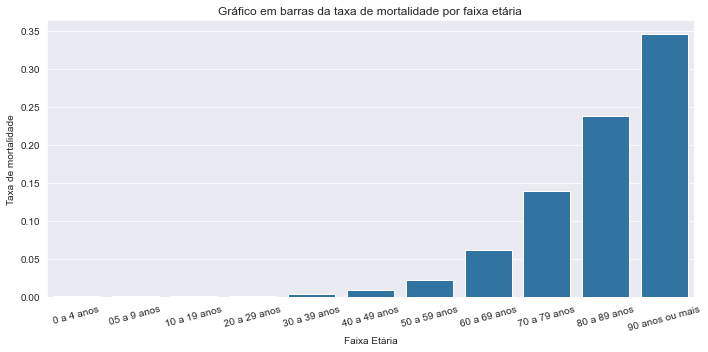

In [34]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="FaixaEtaria", y="Obito", data=df, color=base_color, ci=0)
#Polish plot
plt.xticks(rotation=15);
plt.title('Gráfico em barras da taxa de mortalidade por faixa etária');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Faixa Etária');
plt.tight_layout()
plt.savefig('MortIdade')

A mortalidade aumenta exponencialmente com a idade, como esperado, chegando a 25% entre 80 e 89 anos e 35% para além de 90 anos.

### Qual impacto do sexo na taxa de mortalidade?

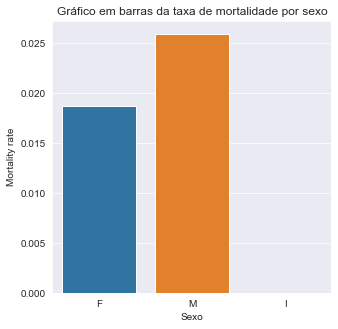

In [35]:
plt.figure(figsize = [5, 5]) 
ax = sns.barplot(x="Sexo", y="Obito", data=df, ci=0)
#Polish plot
plt.title('Gráfico em barras da taxa de mortalidade por sexo');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Sexo');
plt.ylabel('Mortality rate');

Homens tem uma taxa de mortalidade bem maior que mulheres (2.5% a 1.9%) e nenhuma pessoa intersexo morreu por Covid-19, mas temos poucos intersexo na base de dados.

### Qual o impacto de gravidez na taxa de mortalidade?

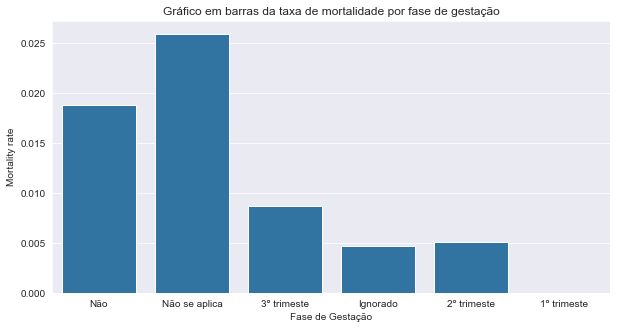

In [36]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="Gestante", y="Obito", data=df, color=base_color, ci=0)
#Polish plot
plt.title('Gráfico em barras da taxa de mortalidade por fase de gestação');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Fase de Gestação');
plt.ylabel('Mortality rate');

Gestantes tem menor taxa de mortalidade, talvez devido a um maior acompanhamento médico.

### Qual o impacto de deficiencia na taxa de mortalidade?

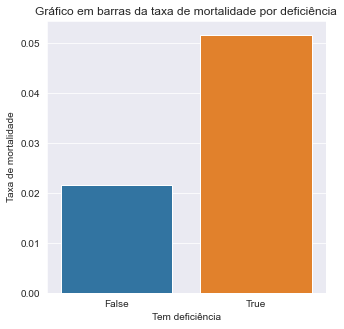

In [37]:
plt.figure(figsize = [5, 5]) 
ax = sns.barplot(x="PossuiDeficiencia", y="Obito", data=df, ci=0)
#Polish plot
plt.title('Gráfico em barras da taxa de mortalidade por deficiência');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Tem deficiência');

Como esperado pessoas com deficiencia tem maior taxa de mortalidade (cerca de 5%).

### Qual o impacto da escolaridade na taxa de mortalidade?

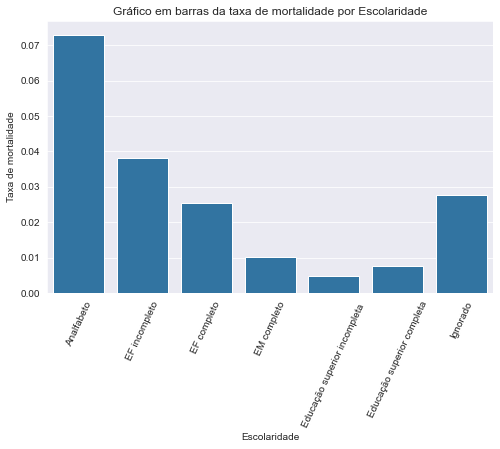

In [38]:
plt.figure(figsize = [8, 5]) 
ax = sns.barplot(x="Escolaridade", y="Obito", data=df, color=base_color, ci=0)
#Polish plot
plt.xticks(rotation=65);
plt.title('Gráfico em barras da taxa de mortalidade por Escolaridade');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Escolaridade');

Como esperado pessoas de escolaridade menor tem mais vulnerabilidade social e logo maior taxa de mortalidade, chegando a mais de 7% entre analfabetos e cerca de 1% em pessoas com EM completo.

### Qual impacto da cor na taxa de mortalidade?

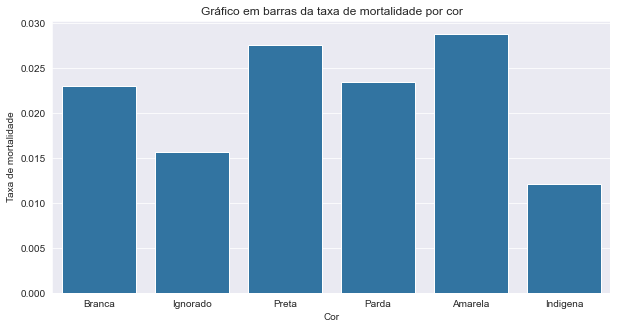

In [39]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="RacaCor", y="Obito", data=df, ci=0, color=base_color)
#Polish plot
plt.title('Gráfico em barras da taxa de mortalidade por cor');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Cor');

Cor tem uma diferença de mortalidade menor que a esperada, mas ainda assim tem uma diferença, com pessoas pretas e amarelas com cerca de 2.75% de mortalidade e pessoas brancas com 2.25%. O mais inesperado é que indígenas tem a menor taxa de mortalidade com cerca de 1.2%.

### Qual a mortalidade para profissionais de saúde?

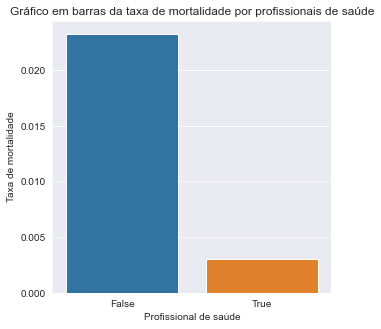

In [40]:
plt.figure(figsize = [5, 5]) 
ax = sns.barplot(x="ProfissionalSaude", y="Obito", data=df, ci=0)
#Polish plot
plt.title('Gráfico em barras da taxa de mortalidade por profissionais de saúde');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Profissional de saúde');

Diferente do esperado, profissionais de saúde tem uma taxa de mortalidade muito menor, com cerca de 0.3% apenas.

### Qual a mortalidade para moradores de rua?

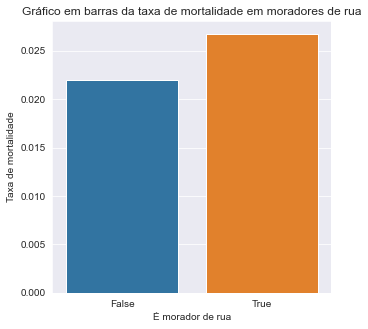

In [41]:
plt.figure(figsize = [5, 5]) 
ax = sns.barplot(x="MoradorDeRua", y="Obito", data=df, ci=0)
#Polish plot
plt.title('Gráfico em barras da taxa de mortalidade em moradores de rua');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('É morador de rua');

Moradores de rua tem uma leve maior taxa de mortalidade, cerca de 2.6%.

### Qual o impacto de viagens nacionais na taxa de mortalidade?

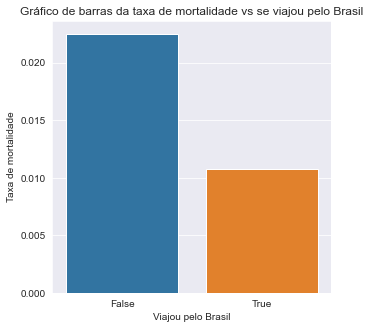

In [42]:
plt.figure(figsize = [5, 5]) 
ax = sns.barplot(x="ViagemBrasil", y="Obito", data=df, ci=0)
#Polish plot
plt.title('Gráfico de barras da taxa de mortalidade vs se viajou pelo Brasil');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Viajou pelo Brasil');

Pessoas que viajaram pelo Brasil tem uma mortalidade menor, cerca de 1%.

### Qual o impacto de viagens internacionais na taxa de mortalidade?

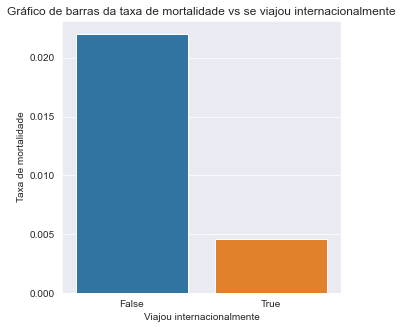

In [43]:
plt.figure(figsize = [5, 5]) 
ax = sns.barplot(x="ViagemInternacional", y="Obito", data=df, ci=0)
#Polish plot
plt.title('Gráfico de barras da taxa de mortalidade vs se viajou internacionalmente');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Viajou internacionalmente');

Pessoas que viajaram internacionalmente tem uma taxa de mortalidade muito menor, cerca de 0.5%

### Resultados que eram esperados

Temos alguns resultados, que eram esperados, interessantes, os principais sendo:
- Quanto mais velho o paciente maior a taxa de mortalidade.
- Comorbidades aumentam a taxa de mortalidade, especialmente comorbidade renal.
- Quanto menor a escolaridade maior a taxa de mortalidade.

### Resultados que não eram esperados

Temos alguns resultados não esperados que exploraremos mais na próxima sessão, sendo os principais:
- A cor do paciente não traz um grande impacto na taxa de mortalidade.
- Profissionais de saúde tem uma taxa de mortalidade menor.

## Exploração multivariável

Vou entender agora como diferentes características atuam na taxa de mortalidade, inicialmente olhando para sexo e faixa etária

### Qual impacto do sexo na taxa de mortalidade em cada idade?

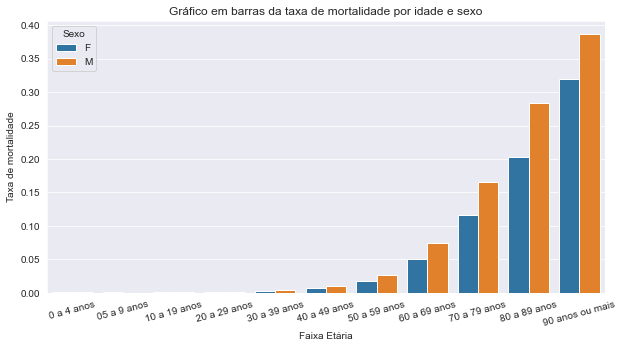

In [44]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="FaixaEtaria", y="Obito", hue='Sexo', data=df[df['Sexo']!="I"], ci=0)
#Polish plot
plt.xticks(rotation=15);
plt.title('Gráfico em barras da taxa de mortalidade por idade e sexo');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Faixa Etária');

Vemos que sexo apenas aumenta a mortalidade apenas a partir dos 30 anos, mas mais especialmente a partir dos 40 anos. Por esses dados não sabemos se a razão pra essa mortalidade é devido a causas biológicas ou sociais.

Outra característica que não agiu como esperado foi taxa de mortalidade com a cor dos pacientes, então vamos observar melhor essa característica.

### Qual impacto de diferentes características sociais na mortalidade por cor?

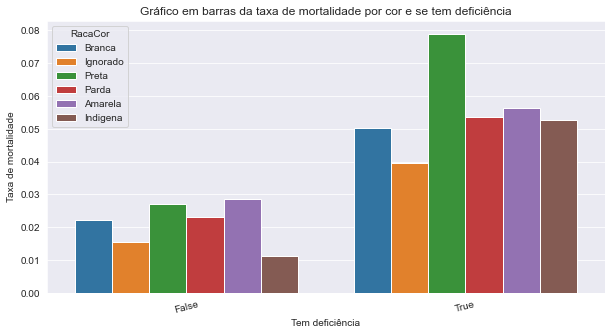

In [45]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="PossuiDeficiencia", y="Obito", hue='RacaCor', data=df, ci=0)
#Polish plot
plt.xticks(rotation=15);
plt.title('Gráfico em barras da taxa de mortalidade por cor e se tem deficiência');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Tem deficiência');

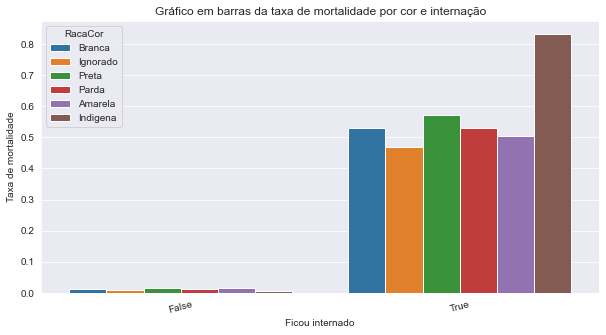

In [46]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="FicouInternado", y="Obito", hue='RacaCor', data=df, ci=0)
#Polish plot
plt.xticks(rotation=15);
plt.title('Gráfico em barras da taxa de mortalidade por cor e internação');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Ficou internado');

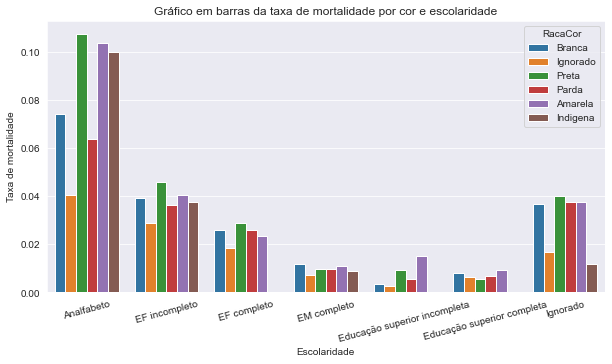

In [47]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="Escolaridade", y="Obito", hue='RacaCor', data=df, ci=0)
#Polish plot
plt.xticks(rotation=15);
plt.ylabel('Mortality rate');
plt.title('Gráfico em barras da taxa de mortalidade por cor e escolaridade');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Escolaridade');

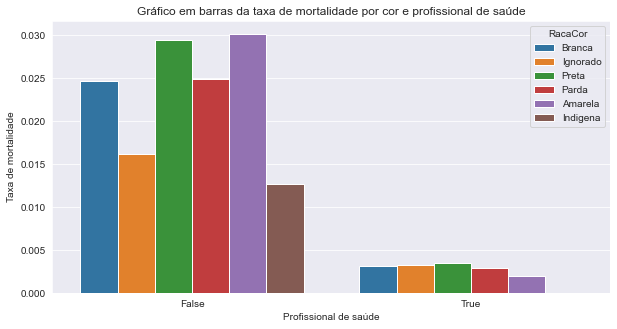

In [48]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="ProfissionalSaude", y="Obito", hue='RacaCor', data=df, ci=0)
#Polish plot
plt.title('Gráfico em barras da taxa de mortalidade por cor e profissional de saúde');
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Profissional de saúde');

Apesar de a cor não aumentar muito a taxa de mortalidade, quando misturamos cor com outras características, principalmente sociais, vemos maiores diferenças:

1. Pessoas brancas com deficiência tem taxa de mortalidade de de cerca de 8%, enquanto brancos tem apenas 5%.
2. Indígenas hospitalizados tem cerca de 80% de taxa de mortalidade, enquando pessoas de outras cores tem entre 50 e 60%.
3. Dentre analfabetos, negros tem mais de 10% de taxa de mortalidade, enquanto brancos tem 7.5%.
4. Pessoas amarelas tem maior taxa de mortalidade em praticamente qualquer escolaridade.
5. Profissionais de saúde negros tem maior taxa de mortalidade do que qualquer outra.

### Qual impacto de hospitalização na taxa de mortalidade por idade?

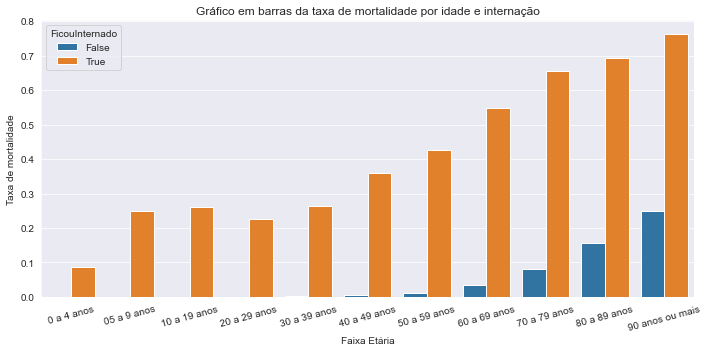

In [49]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="FaixaEtaria", y="Obito", hue='FicouInternado', data=df, ci=0)
#Polish plot
plt.xticks(rotation=15);
plt.ylabel('Taxa de mortalidade');
plt.xlabel('Faixa Etária')
plt.title('Gráfico em barras da taxa de mortalidade por idade e internação');
plt.tight_layout()
plt.savefig("MortIdadeIntern")

A taxa de mortalidade de pessoas hospitalizadas começa a crescer a partir dos 40 anos, antes estando sempre abaixo de 30%, e passando de 75% para pessoas com mais de 90 anos.

### Qual impacto de comorbidades na taxa de mortalidade por idade?

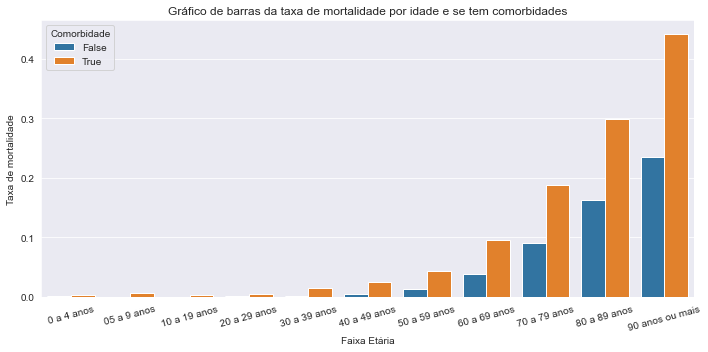

In [50]:
plt.figure(figsize = [10, 5]) 
ax = sns.barplot(x="FaixaEtaria", y="Obito", hue='Comorbidade', data=df, ci=0)
#Polish plot
plt.xticks(rotation=15);
plt.title('Gráfico de barras da taxa de mortalidade por idade e se tem comorbidades')
plt.tight_layout()
plt.xlabel('Faixa Etária')
plt.ylabel('Taxa de mortalidade')
plt.savefig('MortIdComorb')

Comorbidades afetam pacientes de qualquer idade, mas de maneira mais perigosa a partir dos 30 anos de idade.